In [197]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import skew
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score 
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import plotly

In [179]:
# Import and sample dataset
df = pd.read_csv('sales_data_sample.csv')

df

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,10350,20,100.00,15,2244.40,12/2/2004 0:00,Shipped,4,12,2004,...,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Small
2819,10373,29,100.00,1,3978.51,1/31/2005 0:00,Shipped,1,1,2005,...,Torikatu 38,NaN,Oulu,NaN,90110,Finland,EMEA,Koskitalo,Pirkko,Medium
2820,10386,43,100.00,4,5417.57,3/1/2005 0:00,Resolved,1,3,2005,...,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Medium
2821,10397,34,62.24,1,2116.16,3/28/2005 0:00,Shipped,1,3,2005,...,1 rue Alsace-Lorraine,NaN,Toulouse,NaN,31000,France,EMEA,Roulet,Annette,Small


### Create the RFM table

In [180]:
#Create columns: Recency, Frequency, and Monetary

#Subtract the date of last purchase from date of data snapshot to create a recency column
from datetime import datetime
import datetime
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
df['ORDERDATE'] = df['ORDERDATE'].dt.date
snapshot_date = max(df.ORDERDATE) + datetime.timedelta(days=1)

#Sum all transactions for each customer for a monetary column 
df['TotalSum'] = df['QUANTITYORDERED'] * df['PRICEEACH']

#Aggregate data by each customer
customers = df.groupby(['CUSTOMERNAME']).agg({
    'ORDERDATE': lambda x: (snapshot_date - x.max()).days, 
    'CUSTOMERNAME': 'count',
    'TotalSum': 'sum'})

#Rename columns
customers.rename(columns = {'ORDERDATE': 'Recency',
                            'CUSTOMERNAME': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)
customers

,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",196,51,136873.25
Alpha Cognac,65,20,58885.28
Amica Models & Co.,265,26,72645.01
"Anna's Decorations, Ltd",84,46,121260.41
Atelier graphique,188,7,21213.16
...,...,...,...
"Vida Sport, Ltd",275,31,93344.91
Vitachrome Inc.,208,25,67511.37
"Volvo Model Replicas, Co",194,19,58374.21


### Plot distribution of Recency, Frequency and MonetaryValue  

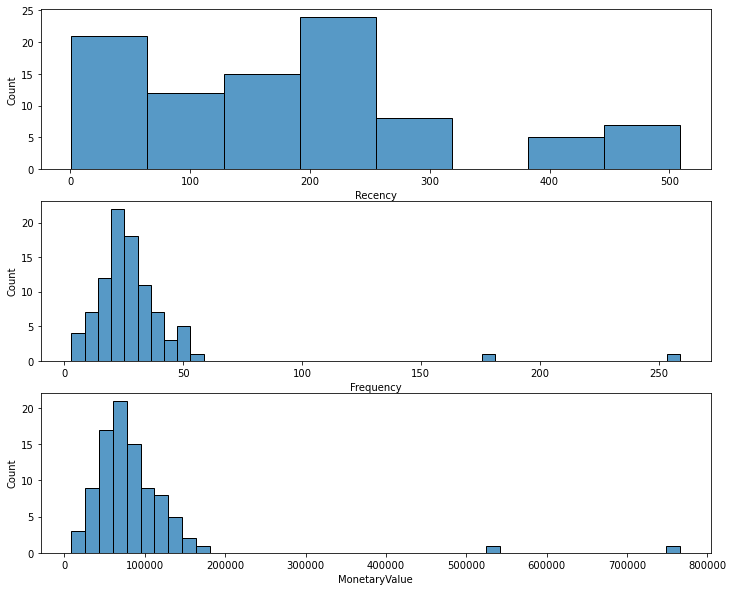

In [181]:
plt.figure(figsize=(12,10))

# Plot distribution of Recency
plt.subplot(3, 1, 1); sns.histplot(customers['Recency'])

# Plot distribution of Frequency
plt.subplot(3, 1, 2); sns.histplot(customers['Frequency'])

# Plot distribution of Monetary Value
plt.subplot(3, 1, 3); sns.histplot(customers['MonetaryValue'])

plt.show()

In [182]:
for col in customers: 
    print(col) 
    print(skew(customers[col])) 

Recency
0.7673634065510249
Frequency
5.653296151215707
MonetaryValue
5.677526777814111


### Remove Skew

In [183]:
customers['Frequency'] = np.log(customers['Frequency'])
pd.Series(customers['Frequency']).skew()

0.3218634062203173

In [184]:
customers['Recency'] = np.sqrt(customers['Recency'])
pd.Series(customers['Recency']).skew()

-0.2471246156866106

In [185]:
customers['MonetaryValue'] = np.log(customers['MonetaryValue'])
pd.Series(customers['MonetaryValue']).skew()

0.33443750123507265

<AxesSubplot:xlabel='MonetaryValue', ylabel='Count'>

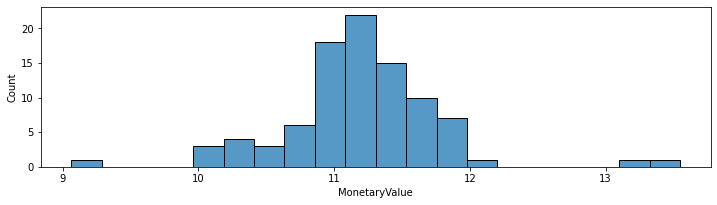

In [186]:
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 3); sns.histplot(customers['MonetaryValue'])

<AxesSubplot:xlabel='Recency', ylabel='Count'>

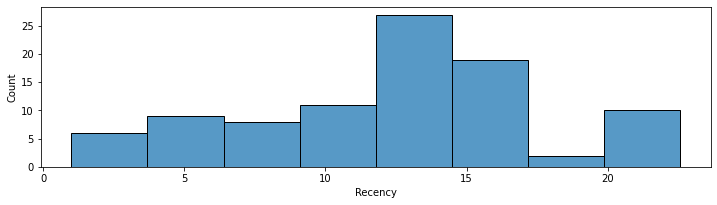

In [187]:
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 3); sns.histplot(customers['Recency'])

<AxesSubplot:xlabel='Frequency', ylabel='Count'>

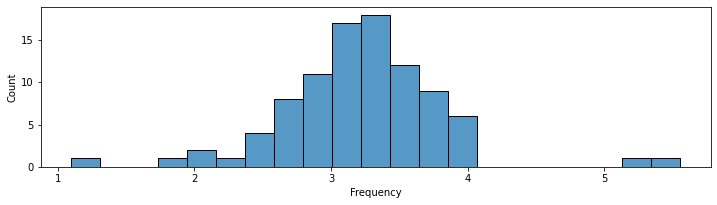

In [188]:
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 3); sns.histplot(customers['Frequency'])

### Correlation Analysis

<AxesSubplot:>

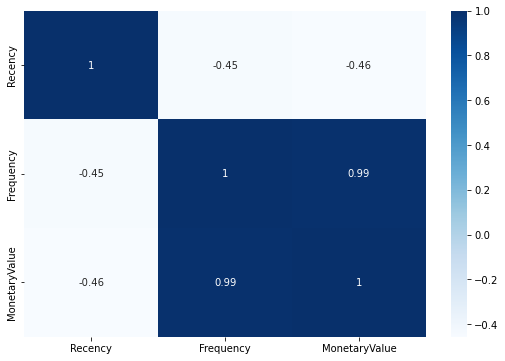

In [190]:
fig, ax = plt.subplots(figsize=(9,6))   
sns.heatmap(customers.corr(),cmap='Blues',annot=True,ax=ax)

### Q-Q plot- check on data distribution

In [191]:
def q_qplot(col, df): 
    fig, ax=plt.subplots()
    stats.probplot(df[col],dist='norm', plot=ax) 
    ax.set_title(f'Q-Q plot({col})') 
    plt.show() 

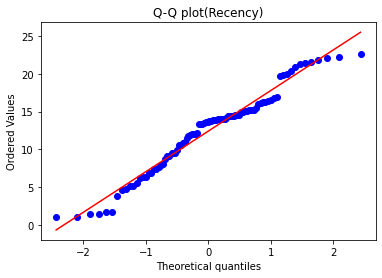

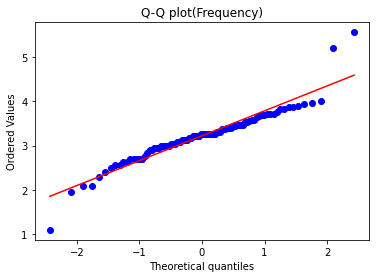

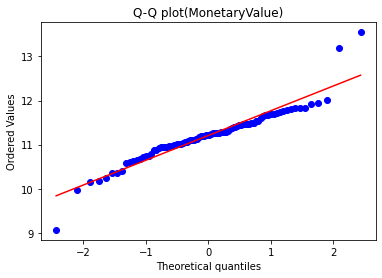

In [192]:
q_qplot('Recency', customers) 
q_qplot('Frequency', customers) 
q_qplot('MonetaryValue', customers) 

### Feature Scaling

In [195]:
scaler=StandardScaler() 
customers_standardized=scaler.fit_transform(customers) 

Fit KMeans and calculate sse, Silhouette score for each k 

/Users/noe/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/noe/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


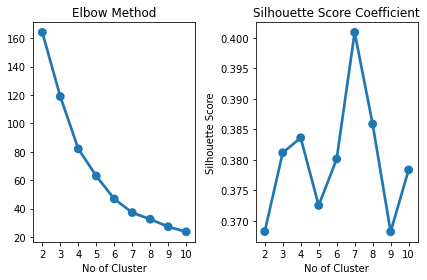

In [201]:
sse={} 
Silhouette_score={} 
for k in range(2, 11): 
    kmeans= KMeans(init='k-means++', n_clusters=k, random_state=0) 
    kmeans.fit(customers_standardized) 
    sse[k]=kmeans.inertia_ 
    
    labels= kmeans.labels_ 
    Silhouette_score[k]=silhouette_score(customers_standardized, labels) 
    
fig, (ax1, ax2)= plt.subplots(1,2) 

#Plot elbow method 
sns.pointplot(list(sse.keys()), list(sse.values()), ax=ax1) 
ax1.set_xlabel('No of Cluster') 
ax1.set_title('Elbow Method')

#Plot silhouette coefficient 
sns.pointplot(list(Silhouette_score.keys()), list(Silhouette_score.values()), ax=ax2) 
ax2.set_title('Silhouette Score Coefficient') 
ax2.set_xlabel('No of Cluster') 
ax2.set_ylabel('Silhouette Score') 
fig.tight_layout() 

### KMeans w/ 5 Clusters 

In [202]:
kmeans=KMeans(n_clusters=5, init='k-means++', random_state=0) 
kmeans.fit(customers_standardized) 

KMeans(n_clusters=5, random_state=0)

In [203]:
#Assign value of cluster in original DataFrame 
labels=kmeans.labels_ 
customers=customers.assign(Cluster=labels)

In [205]:
#Take average value of Recency, Frequency and MonetaryValue for each cluster 
customer_cluster=customers.groupby(by=['Cluster']).agg({'Recency':'mean', 
                                                        'Frequency':'mean',
                                                        'MonetaryValue':'mean', 
                                                        'Cluster':'count'}).rename(columns={'Cluster':'count'}) 
customer_cluster                   

,Recency,Frequency,MonetaryValue,count
Cluster,,,,
0,1.366025,5.374892,13.365466,2
1,14.197492,3.381196,11.349565,38
2,17.823962,2.779112,10.761988,21
3,12.833123,1.901198,9.917717,5
4,6.238517,3.437909,11.439717,26
